# Import packages

In [5]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
#import lightgbm as lgb
df = pd.read_csv('https://s3.amazonaws.com/bigdatafinalkami/train.tsv', sep = '\t')

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.5f}'.format)

# Explore data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [5]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00000,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00000,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00000,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00000,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00000,0,Complete with certificate of authenticity


In [6]:
# NA values in 3 columns, need to deal with them later
df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [7]:
# the standard deviation of price is around 38.6
df.price.describe()

count   1482535.00000
mean         26.73752
std          38.58607
min           0.00000
25%          10.00000
50%          17.00000
75%          29.00000
max        2009.00000
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution')

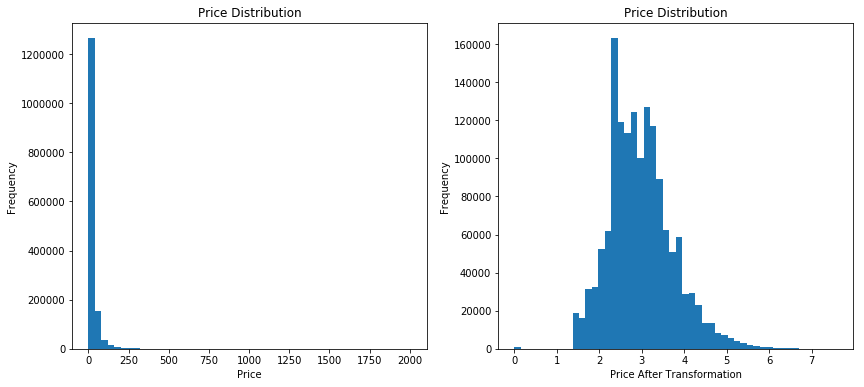

In [97]:
# price is right-skewed, need to transform it using logarithm
plt.subplot(1, 2, 1)
(df['price']).plot.hist(bins=50, figsize=(14, 6))
plt.xlabel('Price')
plt.title('Price Distribution')
plt.subplot(1, 2, 2)
np.log(df['price']+1).plot.hist(bins=50, figsize=(14, 6))
plt.xlabel('Price After Transformation')
plt.title('Price Distribution')

In [98]:
# 55% of the products have shipping fee paid by buyers
df['shipping'].value_counts() / len(df)

0   0.55273
1   0.44727
Name: shipping, dtype: float64

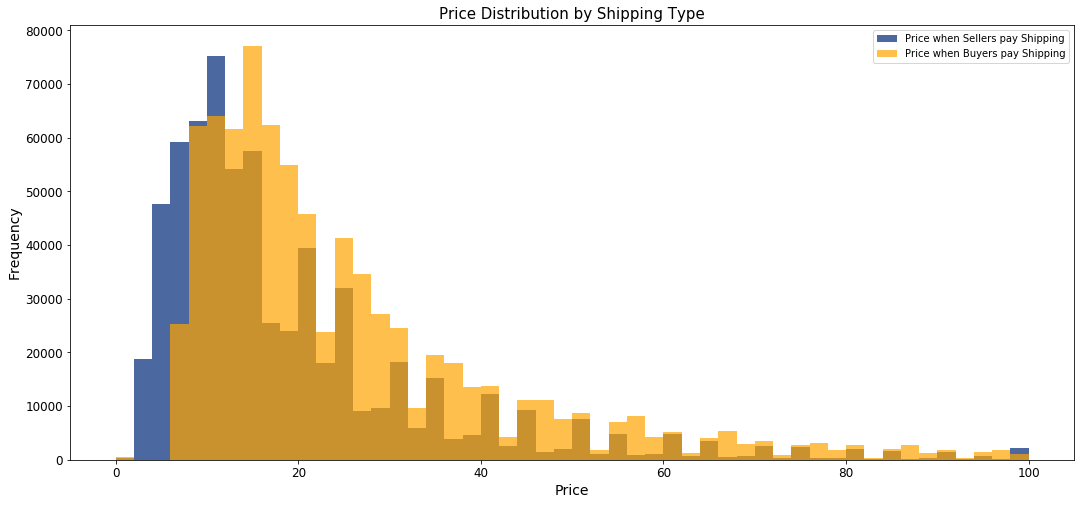

In [99]:
# we observed an obvious difference between sales price and shipping type
shipping_buyer = df.loc[df['shipping'] == 0, 'price']
shipping_seller = df.loc[df['shipping'] == 1, 'price']
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_seller, color='#002878', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Sellers pay Shipping')
ax.hist(shipping_buyer, color='orange', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyers pay Shipping')
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [12]:
#print('The average price is {}'.format(round(shipping_seller.mean(), 2)), 'if seller pays shipping');
#print('The average price is {}'.format(round(shipping_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.55 if seller pays shipping
The average price is 30.16 if buyer pays shipping


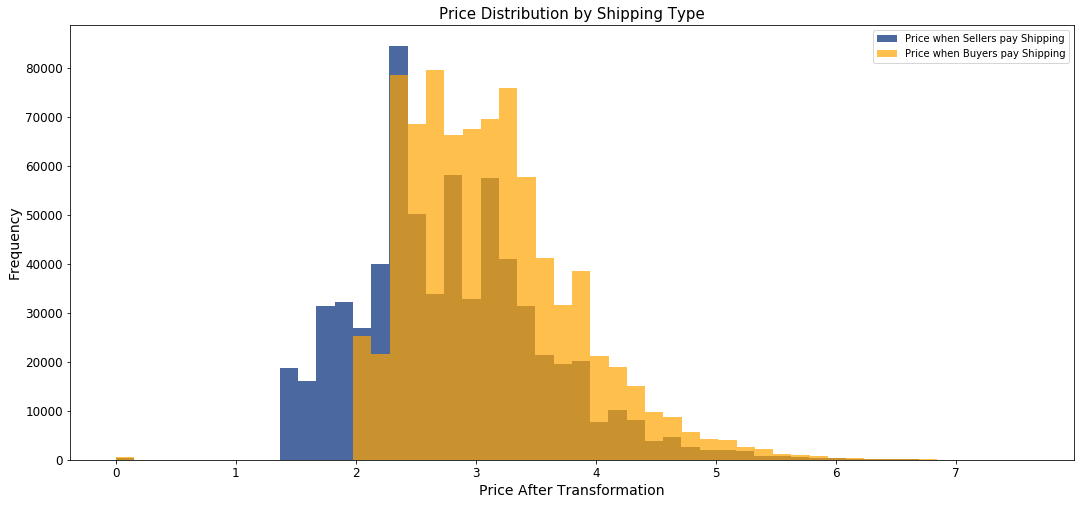

In [100]:
# the pattern is similar for transformed price
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_seller+1), color='#002878', alpha=0.7, bins=50,
       label='Price when Sellers pay Shipping')
ax.hist(np.log(shipping_buyer+1), color='orange', alpha=0.7, bins=50,
       label='Price when Buyers pay Shipping')
plt.xlabel('Price After Transformation', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

# Data cleaning

In [7]:
# deal with missing values in columns
df['category_name'].fillna(value='missing', inplace=True)
df['brand_name'].fillna(value='missing', inplace=True)
df['item_description'].replace('No description yet','missing', inplace=True)
df['item_description'].fillna(value='missing', inplace=True)

In [9]:
df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [8]:
# trainig, test split
train, test = train_test_split(df, test_size=0.2, random_state=1122)
train.shape, test.shape

((1186028, 8), (296507, 8))

In [9]:
# for brands in test data which are not in training data, categorize then as "missing"
brand_list = train['brand_name'].unique()
test.loc[~test['brand_name'].isin(brand_list), 'brand_name'] = 'missing'

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
# split category name into 3 columns based on "/"
train['main_cat'] = train['category_name'].str.split('/', n=2, expand=True)[0]
train['subcat_1'] = train['category_name'].str.split('/', n=2, expand=True)[1]
train['subcat_2'] = train['category_name'].str.split('/', n=2, expand=True)[2]

train.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_cat,subcat_1,subcat_2
1238931,1238931,American eagle shorts,2,Women/Athletic Apparel/Shorts,American Eagle,15.00000,1,Practically new size 0,Women,Athletic Apparel,Shorts
791807,791807,35 Mixed Mailers,1,Other/Office supplies/Shipping Supplies,missing,8.00000,1,"(5) 10x13 ( Blue, Green, Purple, Pink) (5) 9x1...",Other,Office supplies,Shipping Supplies
661553,661553,Tarte pro glow to go,1,Beauty/Makeup/Face,Tarte,12.00000,1,missing,Beauty,Makeup,Face
188650,188650,Michael Kors watch (rose gold),3,Women/Women's Accessories/Watches,Michael Kors,55.00000,1,Missing one rock. Worn twice. The bling is ver...,Women,Women's Accessories,Watches
1400779,1400779,mnk Boutique Medium Black Blouse,3,Women/Tops & Blouses/Blouse,missing,7.00000,1,Could fit Small too!,Women,Tops & Blouses,Blouse


In [11]:
# do the same thing for test
test['main_cat'] = test['category_name'].str.split('/', n=2, expand=True)[0]
test['subcat_1'] = test['category_name'].str.split('/', n=2, expand=True)[1]
test['subcat_2'] = test['category_name'].str.split('/', n=2, expand=True)[2]

test.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_cat,subcat_1,subcat_2
398529,398529,Neptune - Seahorse Beanie Boo,3,Kids/Toys/Stuffed Animals & Plush,missing,6.00000,1,It does have scratches on the eyes. Smoke and ...,Kids,Toys,Stuffed Animals & Plush
586577,586577,Adidas size 4 youth ON HOLD,2,Kids/Boys 2T-5T/Shoes,missing,15.00000,1,7/10 condition size 4 in kids I'm a 6.5 in wom...,Kids,Boys 2T-5T,Shoes
614137,614137,NWT Heart Eyes Emoji Chia Pet,1,Home/Home Décor/Home Décor Accents,missing,10.00000,0,"*NWT* unused, still in original packaging hear...",Home,Home Décor,Home Décor Accents
120038,120038,Women's Isabella Costas,3,Women/Women's Accessories/Sunglasses,missing,39.00000,0,Isabella style women's Costas in tortoise shel...,Women,Women's Accessories,Sunglasses
1361767,1361767,DO NOT BUY! BUNDLE 4 ElNewbern,2,Women/Jewelry/Necklaces,missing,25.00000,0,Do not buy! Bundle 4 Elnewbern 1 lion necklace...,Women,Jewelry,Necklaces


In [12]:
train['subcat_1'].fillna(value='missing', inplace=True)
train['subcat_2'].fillna(value='missing', inplace=True)
test['subcat_1'].fillna(value='missing', inplace=True)
test['subcat_2'].fillna(value='missing', inplace=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [13]:
# for categories in test data which are not in training data, categorize then as "missing"
cat_list = train['main_cat'].unique()
test.loc[~test['main_cat'].isin(cat_list), 'main_cat'] = 'missing'

catsub_list = train['subcat_1'].unique()
test.loc[~test['subcat_1'].isin(catsub_list), 'subcat_1'] = 'missing'

catsub_list2 = train['subcat_2'].unique()
test.loc[~test['subcat_2'].isin(catsub_list2), 'subcat_2'] = 'missing'

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
# drop category_name
train = train.drop(['category_name'], axis=1)
test = test.drop(['category_name'], axis=1)

In [53]:
train.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_cat,subcat_1,subcat_2
1238931,1238931,American eagle shorts,2,American Eagle,15.00000,1,Practically new size 0,Women,Athletic Apparel,Shorts
791807,791807,35 Mixed Mailers,1,missing,8.00000,1,"(5) 10x13 ( Blue, Green, Purple, Pink) (5) 9x1...",Other,Office supplies,Shipping Supplies
661553,661553,Tarte pro glow to go,1,Tarte,12.00000,1,missing,Beauty,Makeup,Face
188650,188650,Michael Kors watch (rose gold),3,Michael Kors,55.00000,1,Missing one rock. Worn twice. The bling is ver...,Women,Women's Accessories,Watches
1400779,1400779,mnk Boutique Medium Black Blouse,3,missing,7.00000,1,Could fit Small too!,Women,Tops & Blouses,Blouse


In [15]:
def to_categorical(dataset):
    dataset['main_cat'] = dataset['main_cat'].astype('category')
    dataset['subcat_1'] = dataset['subcat_1'].astype('category')
    dataset['subcat_2'] = dataset['subcat_2'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')
    dataset['shipping'] = dataset['shipping'].astype('category')

In [16]:
to_categorical(train)
to_categorical(test)

In [56]:
train.dtypes

train_id                int64
name                   object
item_condition_id    category
brand_name           category
price                 float64
shipping                int64
item_description       object
main_cat             category
subcat_1             category
subcat_2             category
dtype: object

In [17]:
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])
train = train[train.price != 0].reset_index(drop=True)

In [18]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
train = train.drop('price', axis=1)
merge = pd.concat([train, test_new])

In [59]:
merge.head()

,train_id,name,item_condition_id,brand_name,shipping,item_description,main_cat,subcat_1,subcat_2
0,1238931,American eagle shorts,2,American Eagle,1,Practically new size 0,Women,Athletic Apparel,Shorts
1,791807,35 Mixed Mailers,1,missing,1,"(5) 10x13 ( Blue, Green, Purple, Pink) (5) 9x1...",Other,Office supplies,Shipping Supplies
2,661553,Tarte pro glow to go,1,Tarte,1,missing,Beauty,Makeup,Face
3,188650,Michael Kors watch (rose gold),3,Michael Kors,1,Missing one rock. Worn twice. The bling is ver...,Women,Women's Accessories,Watches
4,1400779,mnk Boutique Medium Black Blouse,3,missing,1,Could fit Small too!,Women,Tops & Blouses,Blouse


In [60]:
merge.shape, train.shape

((1481834, 9), (1185327, 9))

In [19]:
# tokenize name and categories
cv = CountVectorizer(min_df = 10)
X_name = cv.fit_transform(merge['name'])
cv = CountVectorizer()
X_main_cat = cv.fit_transform(merge['main_cat'])
X_subcat_1 = cv.fit_transform(merge['subcat_1'])
X_subcat_2 = cv.fit_transform(merge['subcat_2'])

In [70]:
print(X_subcat_1)

  (0, 6)	1
  (0, 10)	1
  (1, 121)	1
  (1, 89)	1
  (2, 78)	1
  (3, 3)	1
  (3, 139)	1
  (4, 19)	1
  (4, 129)	1
  (5, 136)	1
  (6, 6)	1
  (6, 10)	1
  (7, 73)	1
  (8, 44)	1
  (9, 136)	1
  (10, 78)	1
  (11, 78)	1
  (12, 81)	1
  (12, 3)	1
  (13, 123)	1
  (14, 111)	1
  (14, 49)	1
  (15, 57)	1
  (16, 110)	1
  (17, 73)	1
  :	:
  (1481817, 55)	1
  (1481818, 123)	1
  (1481819, 78)	1
  (1481820, 72)	1
  (1481821, 6)	1
  (1481821, 10)	1
  (1481822, 129)	1
  (1481823, 52)	1
  (1481824, 123)	1
  (1481825, 3)	1
  (1481825, 139)	1
  (1481826, 136)	1
  (1481827, 136)	1
  (1481828, 2)	1
  (1481828, 1)	1
  (1481828, 57)	1
  (1481829, 78)	1
  (1481830, 123)	1
  (1481831, 6)	1
  (1481831, 10)	1
  (1481832, 84)	1
  (1481832, 0)	1
  (1481832, 23)	1
  (1481833, 6)	1
  (1481833, 10)	1


In [20]:
tv = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [91]:
type(X_description)

scipy.sparse.csr.csr_matrix

In [21]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [68]:
merge.head(20)

,train_id,name,item_condition_id,brand_name,shipping,item_description,main_cat,subcat_1,subcat_2
0,1238931,American eagle shorts,2,American Eagle,1,Practically new size 0,Women,Athletic Apparel,Shorts
1,791807,35 Mixed Mailers,1,missing,1,"(5) 10x13 ( Blue, Green, Purple, Pink) (5) 9x1...",Other,Office supplies,Shipping Supplies
2,661553,Tarte pro glow to go,1,Tarte,1,missing,Beauty,Makeup,Face
3,188650,Michael Kors watch (rose gold),3,Michael Kors,1,Missing one rock. Worn twice. The bling is ver...,Women,Women's Accessories,Watches
4,1400779,mnk Boutique Medium Black Blouse,3,missing,1,Could fit Small too!,Women,Tops & Blouses,Blouse
5,436407,Hold for Angelina Ragonese,1,missing,1,@@This silicone bra is different from regular ...,Women,Underwear,Bras
6,309010,Victoria Sport Sports Bra,3,Victoria's Secret,0,Women's sports bra no holes no tears.,Women,Athletic Apparel,Sports Bras
7,1187424,⚠Read Below⚠ 2 Bracelets Set,1,missing,1,Black Woven bracelet and Gold Metal Bead Brace...,Women,Jewelry,Bracelets
8,552377,Dansiki African skirt,1,missing,0,missing,Women,Dresses,Knee-Length
9,176144,VS DREAM ANGELS UNLINED DEMI BRA 32C,1,Victoria's Secret,1,VS DREAM ANGELS UNLINED DEMI BRA 32C This list...,Women,Underwear,Bras


In [70]:
print(X_brand)

  (0, 201)	1
  (1, 4483)	1
  (2, 3923)	1
  (3, 2653)	1
  (4, 4483)	1
  (5, 4483)	1
  (6, 4222)	1
  (7, 4483)	1
  (8, 4483)	1
  (9, 4222)	1
  (10, 4483)	1
  (11, 4483)	1
  (12, 4434)	1
  (13, 852)	1
  (14, 4483)	1
  (15, 69)	1
  (16, 4180)	1
  (17, 4483)	1
  (18, 4483)	1
  (19, 4483)	1
  (20, 1579)	1
  (21, 4483)	1
  (22, 3006)	1
  (23, 2304)	1
  (24, 4483)	1
  :	:
  (1481809, 2470)	1
  (1481810, 4483)	1
  (1481811, 1695)	1
  (1481812, 4204)	1
  (1481813, 4483)	1
  (1481814, 497)	1
  (1481815, 4483)	1
  (1481816, 4483)	1
  (1481817, 4483)	1
  (1481818, 4483)	1
  (1481819, 4389)	1
  (1481820, 1808)	1
  (1481821, 4483)	1
  (1481822, 1826)	1
  (1481823, 4222)	1
  (1481824, 3006)	1
  (1481825, 4483)	1
  (1481826, 4483)	1
  (1481827, 4222)	1
  (1481828, 4483)	1
  (1481829, 2667)	1
  (1481830, 4410)	1
  (1481831, 4483)	1
  (1481832, 4483)	1
  (1481833, 4157)	1


In [22]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

In [76]:
print(X_dummies)

  (0, 1)	1
  (0, 6)	1
  (1, 0)	1
  (1, 6)	1
  (2, 0)	1
  (2, 6)	1
  (3, 2)	1
  (3, 6)	1
  (4, 2)	1
  (4, 6)	1
  (5, 0)	1
  (5, 6)	1
  (6, 2)	1
  (6, 5)	1
  (7, 0)	1
  (7, 6)	1
  (8, 0)	1
  (8, 5)	1
  (9, 0)	1
  (9, 6)	1
  (10, 0)	1
  (10, 6)	1
  (11, 2)	1
  (11, 6)	1
  (12, 0)	1
  :	:
  (1481821, 5)	1
  (1481822, 2)	1
  (1481822, 5)	1
  (1481823, 0)	1
  (1481823, 6)	1
  (1481824, 2)	1
  (1481824, 5)	1
  (1481825, 2)	1
  (1481825, 5)	1
  (1481826, 2)	1
  (1481826, 5)	1
  (1481827, 0)	1
  (1481827, 5)	1
  (1481828, 0)	1
  (1481828, 6)	1
  (1481829, 0)	1
  (1481829, 6)	1
  (1481830, 2)	1
  (1481830, 6)	1
  (1481831, 0)	1
  (1481831, 6)	1
  (1481832, 2)	1
  (1481832, 5)	1
  (1481833, 2)	1
  (1481833, 5)	1


In [23]:
sparse_merge = hstack((X_name, X_main_cat, X_subcat_1, X_subcat_2, X_description, X_brand, X_dummies)).tocsr()

In [84]:
print(sparse_merge)

  (0, 1402)	1.0
  (0, 5444)	1.0
  (0, 14215)	1.0
  (0, 17746)	1.0
  (0, 17753)	1.0
  (0, 17757)	1.0
  (0, 18645)	1.0
  (0, 47356)	0.16391115486698465
  (0, 47933)	0.46065459332705827
  (0, 52460)	0.5724647239197893
  (0, 52463)	0.6343151353070466
  (0, 59026)	0.17566709408621847
  (0, 69055)	1.0
  (0, 73360)	1.0
  (0, 73365)	1.0
  (1, 554)	1.0
  (1, 9821)	1.0
  (1, 10486)	1.0
  (1, 17742)	1.0
  (1, 17836)	1.0
  (1, 17868)	1.0
  (1, 18639)	1.0
  (1, 18713)	1.0
  (1, 18933)	0.07799009168085859
  (1, 18961)	0.09470360878742733
  :	:
  (1481833, 22294)	0.23805012529725839
  (1481833, 26102)	0.12700415296038658
  (1481833, 26292)	0.16900154124987207
  (1481833, 26321)	0.21292207458956855
  (1481833, 35868)	0.10279147158102143
  (1481833, 35953)	0.1580294384619618
  (1481833, 35958)	0.28367867605495184
  (1481833, 37044)	0.35986623920137817
  (1481833, 39188)	0.14696739677194215
  (1481833, 39197)	0.27853516399777795
  (1481833, 39199)	0.2992697196877632
  (1481833, 41114)	0.196235107592279


In [24]:
# Remove features with document frequency <= 1
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool) # getnnz, number of non-zero items
sparse_merge = sparse_merge[:, mask]

In [25]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [94]:
print(X)

  (0, 72375)	1.0
  (0, 72370)	1.0
  (0, 68989)	1.0
  (0, 58999)	0.17566709408621847
  (0, 52436)	0.6343151353070466
  (0, 52433)	0.5724647239197893
  (0, 47906)	0.46065459332705827
  (0, 47329)	0.16391115486698465
  (0, 18623)	1.0
  (0, 17757)	1.0
  (0, 17753)	1.0
  (0, 17746)	1.0
  (0, 14215)	1.0
  (0, 5444)	1.0
  (0, 1402)	1.0
  (1, 72375)	1.0
  (1, 72369)	1.0
  (1, 72352)	1.0
  (1, 67235)	0.09539577108035284
  (1, 67233)	0.07269533304229815
  (1, 66802)	0.09027538054005155
  (1, 66801)	0.0785442028440706
  (1, 66793)	0.050571654191805586
  (1, 65793)	0.08484558571988407
  (1, 65792)	0.07788981152881651
  :	:
  (1185326, 68668)	0.21775758889393884
  (1185326, 65457)	0.18120212934297075
  (1185326, 65410)	0.1046646035466375
  (1185326, 59822)	0.342853954050391
  (1185326, 59820)	0.2608523546441746
  (1185326, 58999)	0.07702846862123937
  (1185326, 47289)	0.22790548605615474
  (1185326, 45734)	0.31802275289055715
  (1185326, 45674)	0.13302479844054854
  (1185326, 40644)	0.2350266104746

In [95]:
X.shape

(1185327, 72376)

# Model Building
## Light GBM

In [96]:
train_X = lgb.Dataset(X, label=y)

In [97]:
print(train_X)

In [126]:
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 5,
        'num_leaves': 100,
        'lambda_l1': 1,
        'metric': 'RMSE',
    }

In [127]:
gbm = lgb.train(params, train_set=train_X, num_boost_round=800)

In [128]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [129]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(np.exp(y_test), np.exp(y_pred)) ** 0.5)

The rmse of prediction is: 29.43896077410975


In [36]:
y_pred = pd.read_csv('lgbm.csv')
y_pred = np.asarray(y_pred['0'])

## Ridge Regression

In [42]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(
    solver='auto', fit_intercept=True, alpha=0.5,
    max_iter=100, normalize=False, tol=0.05
)
ridge_model.fit(X, y)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, random_state=None, solver='auto', tol=0.05)

In [43]:
ridge_preds = ridge_model.predict(X_test)

In [44]:
print('The rmse of prediction is:', mean_squared_error(np.exp(y_test), np.exp(ridge_preds)) ** 0.5)

The rmse of prediction is: 28.02594629468272


## Lasso Regression

In [67]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(
    fit_intercept=True, alpha=0.6,
    max_iter=100, normalize=False, tol=0.05
)
lasso_model.fit(X, y)

lasso_preds = lasso_model.predict(X_test)
print('The rmse of prediction is:', mean_squared_error(np.exp(y_test), np.exp(lasso_preds)) ** 0.5)

The rmse of prediction is: 38.949003936788266


## Neural Network


In [27]:
import random as rn
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
from keras import backend as K
from sklearn.metrics import mean_squared_error
from math import sqrt

ModuleNotFoundError: No module named 'keras'

In [ ]:
import random as rn
import tensorflow as tf

np.random.seed(1234)
rn.seed(1234)
tf.set_random_seed(1234)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)

sess = tf.Session(graph=tf.get_default_graph(),config=session_conf)
K.set_session(sess)

priceNN = Sequential()

priceNN.add(Dense(units=4,input_shape=(X.shape[1],),activation="relu",use_bias=True))
priceNN.add(Dense(units=4,input_shape=(X.shape[1],),activation="relu",use_bias=True))
priceNN.add(Dense(units=4,input_shape=(X.shape[1],),activation="relu",use_bias=True))
priceNN.add(Dense(units=1,input_shape=(X.shape[1],),activation="relu",use_bias=True)) # add layer
priceNN.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mean_squared_error']) # configure model
priceNN.fit(X,y,epochs=5,batch_size=50,verbose=0)

nn_preds = priceNN.predict(X_test,batch_size=X_test.shape[0])
print('The rmse of prediction is:', mean_squared_error(np.exp(y_test), np.exp(nn_preds)) ** 0.5)

In [41]:
nn_preds = pd.read_csv('nn.csv')
nn_preds = np.asarray(nn_preds['0'])

# Blending

In [48]:
avg_pred = (y_pred + ridge_preds + nn_preds)/ 3

print('The rmse of prediction is:', mean_squared_error(np.exp(y_test), np.exp(avg_pred)) ** 0.5)

The rmse of prediction is: 27.085785670330452


In [65]:
weighted_avg_pred = y_pred * 0.4 + ridge_preds * 0.2 + nn_preds *0.4

print('The rmse of prediction is:', mean_squared_error(np.exp(y_test), np.exp(weighted_avg_pred)) ** 0.5)

The rmse of prediction is: 27.030468647543316


In [62]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

X_ensemble = np.column_stack((y_pred, ridge_preds, nn_preds))

linear_model.fit(X_ensemble, y_test)

linear_preds = linear_model.predict(X_ensemble)
print('The rmse of prediction is:', mean_squared_error(np.exp(y_test), np.exp(linear_preds)) ** 0.5)

The rmse of prediction is: 26.823295997878493
